# Inverted Single Pendulum

In [1]:
#All of this code has been written from scratch as a personal project. I have used lecture notes and videos from 
#MIT's Underactuated Robotics course as a reference to write this code.
#Link to the course webpage: http://underactuated.csail.mit.edu/Spring2019/index.html

#The goal of this code is to implement the inverted pendulum for the single pendulum.
#This code will utilize the dynamics of the pendulum and invert the pendulum using
#a control law derived from a Lyapunov function to change the pendulum's energy to
#match the energy of the desired angle/angular velocity and a control law derived from
#a LQR to balance the pendulum at the top.

#The pendulum system used is a simple pendulum with damping. The vertical axis going down from the origin
#represents theta=0 with counter-clockwise direction being positive.

import numpy as np
import matplotlib.pyplot as plt
import control
import matplotlib.animation as animation

In [2]:
#Create a class for the pendulum simulation
class SwingUpAndBalancePendulum():

    def __init__(self,control=True):
        self.PendulumParameters()      
        self.computeLQR()
        #Set control to True to see a controlled pendulum, set control to False to see a uncontrolled pendulum
        self.control=control  
        
    #Initialize the parameters of the pendulum system
    def PendulumParameters(self,th_init=0,om_init=0):        
        self.L=1                  #Initialize the link arm length
        self.m=1                  #Initialize mass at end of the link
        self.theta_init=th_init   #Initialize the angle of the joint (in radians)
        self.omega_init=om_init   #Initialize the angular velocity of the joint (in radians/sec)
        self.g=9.81               #Initialize the acceleration due to gravity
        self.b=0                  #Initialize b (the damping coefficient)

        #Define the desired energy state (the energy for the desired angle and angular velocity)
        self.th_des=np.pi   #The desired angle
        self.om_des=0       #The desired angular velocity
        self.E_des=self.energy(self.th_des,self.om_des)    #The energy state based on desired angle and angular velocity

        self.u_lim=1.5     #Define the constraint on the input (limit the magnitude of the input u)
        self.k_Lyap=0.5    #Define the gain constant for the control input based on Lyapunov function
        self.dt=0.025      #Sampling time for simulation

    #Find the energy of the pendulum system
    def energy(self,theta,omega):
        T=(1/2)*self.m*self.L**2*omega**2         #Find the kinetic energy of the system
        U=-self.m*self.g*self.L*np.cos(theta)     #Find the potential energy of the system
        E=T+U                      #Find the total energy of the system
        return E
    
    #Set A and B as the matrices for the linearized pendulum system around the region of theta=np.pi and omega=0.
    #LQR is applied to obtain the gain constants to control the pendulum to stay up
    def computeLQR(self):
        self.A=np.array([[0,1],[self.g/self.L,-self.b/(self.m*self.L**2)]])
        self.B=np.array([[0],[1/(self.m*self.L**2)]])
        self.Q=np.diag((1,1))
        self.R=[1]
        self.S=np.diag((10,1))
        self.k_LQR,s,e=control.lqr(self.A,self.B,self.Q,self.R)
    
    #Find the input value to drive the pendulum system
    def find_input(self,theta,omega):
        if self.control:
            #When theta and omega are close to 0 (i.e. initial theta and omega are all 0), set the input u to the input limit
            #This is done because the input u calculated using a Lyapunov function depends only on omega and not theta.
            #At the state of theta=0 and omega=0, the calculated u will be 0.
            if theta%(2*np.pi)==0 and abs(omega)==0:
                u=self.u_lim
            else:
                #Compute the error of the current states from the desired states
                xbar=np.array([[((theta)%(2*np.pi)-self.th_des)],[omega-self.om_des]])
                
                #If the cost is less than the specified value, compute input u using LQR
                if np.dot(np.transpose(xbar),np.dot(self.S,xbar))<1.5:
                    u=-np.dot(self.k_LQR,xbar)
                    
                #Compute the input u using the control law obtained from the Lyapunov function
                else:
                    u=self.b*omega-self.k_Lyap*omega*(self.energy(theta,omega)-self.E_des)
                    
            #If the magnitude of u is greater than the input limit, set u as the input limit        
            if abs(u)>self.u_lim:
                u=np.sign(u)*self.u_lim
        else:
            u=0      #Set input as 0 when the system is not controlled
        return u

    #Find the angular acceleration of the joint 
    def acc_func(self,theta,omega,u):
        acc=(-self.b*(omega)-self.m*self.g*self.L*np.sin(theta)+u)/(self.m*(self.L**2))
        return acc

    #The fourth order Runge-Kutta method is used to find the theta and omega of the next time step
    def RK4(self,theta,omega,u):
        d_th1=self.dt*omega
        d_om1=self.dt*self.acc_func(theta,omega,u)
        d_th2=self.dt*(omega+d_om1/2)
        d_om2=self.dt*self.acc_func(theta+d_th1/2,omega+d_om1/2,u)
        d_th3=self.dt*(omega+d_om2/2)
        d_om3=self.dt*self.acc_func(theta+d_th2/2,omega+d_om2/2,u)
        d_th4=self.dt*(omega+d_om3)
        d_om4=self.dt*self.acc_func(theta+d_th3,omega+d_om3,u)

        d_th=(d_th1+2*(d_th2+d_th3)+d_th4)/6
        d_om=(d_om1+2*(d_om2+d_om3)+d_om4)/6

        theta_new=theta+d_th
        omega_new=omega+d_om

        return theta_new,omega_new
    
    #Simulate the pendulum system
    def simulate(self,n):
        theta_sim=np.zeros((n))    #Initialize an array for the angles
        omega_sim=np.zeros((n))    #Initialize an array for the angular velocities
        u_sim=np.zeros((n))        #Initialize an array for the control input
        E_sim=np.zeros((n))
        
        theta_sim[0]=self.theta_init     #Set the initial theta to the array
        omega_sim[0]=self.omega_init     #Set the initial omega to the array
        E_sim[0]=self.energy(theta_sim[0],omega_sim[0])
        
        #Find the theta and omega of the next time step by computing the control input and using RK4
        for x in range(1,n):
            u_sim[x-1]=self.find_input(theta_sim[x-1],omega_sim[x-1])
            theta_next,omega_next=self.RK4(theta_sim[x-1],omega_sim[x-1],u_sim[x-1])
            E_sim[x]=self.energy(theta_next,omega_next)
            theta_sim[x]=theta_next
            omega_sim[x]=omega_next

        #Base (Joint 1) location at origin  j1=np.array([0,0])      
        j2=np.array([self.L*np.sin(theta_sim[:]),-self.L*np.cos(theta_sim[:])])  #End effector location
        
        return theta_sim,omega_sim,u_sim,E_sim,j2

    #Print the parameters
    def printParams(self):
        print("L={0:2.3f} m".format(self.L))
        print("m={0:2.3f} kg".format(self.m))
        print("g={0:2.3f} m/s^2".format(self.g))
        print("b={0:2.3f}".format(self.b))
        print("Theta_init={0:2.3f} rad".format(self.theta_init))
        print("Omega_init={0:2.3f} rad/s".format(self.omega_init))
        print("K_Lyap={0:2.3f}".format(self.k_Lyap))
        print("E_des={0:2.3f}".format(self.E_des))
        print("th_des={0:2.3f} rad".format(self.th_des))
        print("om_des={0:2.3f} rad/s".format(self.om_des))
        print("dt={0:2.3f} sec".format(self.dt))

<IPython.core.display.Javascript object>


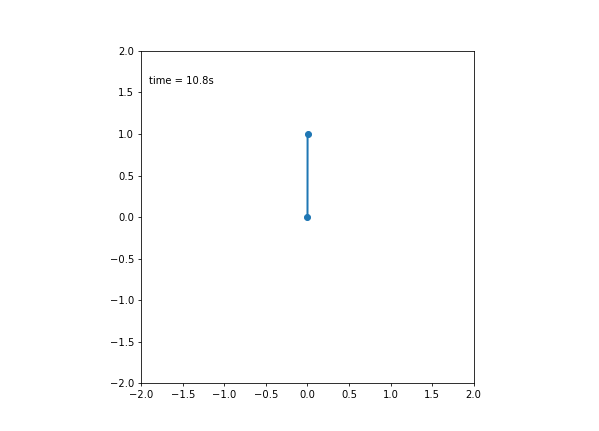

L=1.000 m
m=1.000 kg
g=9.810 m/s^2
b=0.000
Theta_init=0.000 rad
Omega_init=0.000 rad/s
K_Lyap=0.500
E_des=9.810
th_des=3.142 rad
om_des=0.000 rad/s
dt=0.025 sec


In [3]:
#Set the matplotlib animation to show 1 figure during the animation
%matplotlib nbagg     

n=500     #Number of samples

#Initialize the class and simulate the pendulum
pend=SwingUpAndBalancePendulum()
theta_sim,omega_sim,u_sim,E_sim,j2=pend.simulate(n)

#Define the figure for the animation
fig = plt.figure(figsize=(8.333, 6), dpi=80)
ax = fig.add_subplot(111,autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))   
ax.set_aspect('equal')
line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(pend.dt, 0.9, '', transform=ax.transAxes)
    
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text
    
def animate(i):
    thisx = [0, j2[0,i]]
    thisy = [0, j2[1,i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*pend.dt))
    return line, time_text

#Show the animation
ani = animation.FuncAnimation(fig, animate, range(0, n), interval=pend.dt*1000, blit=True, init_func=init)
plt.show()

#Print the parameters
pend.printParams()

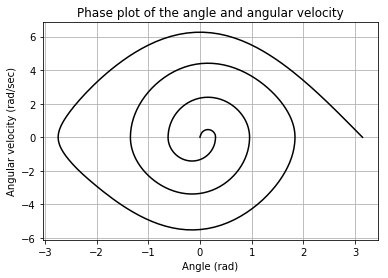

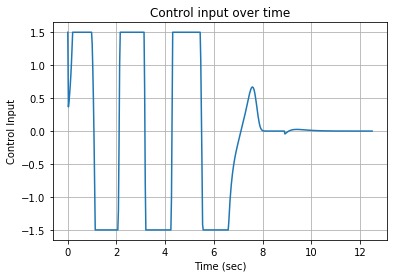

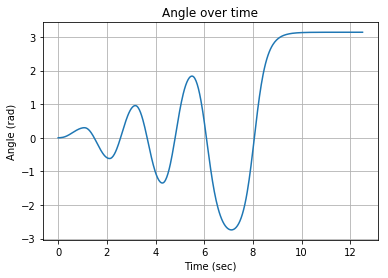

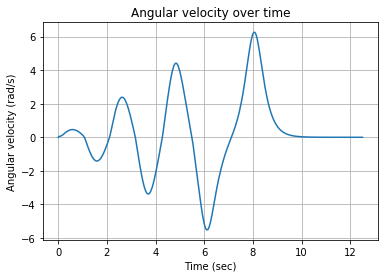

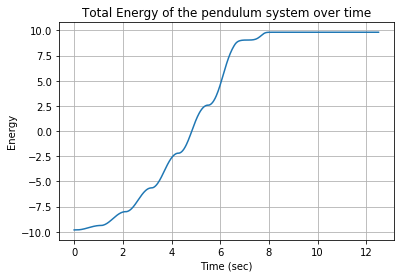

In [4]:
#Set the matplotlib plots to show the plots properly
%matplotlib inline

t=np.linspace(0,pend.dt*n,n)    #Create the time array

#Show the phase plot of the angle and angular velocity
plt.figure(0)
plt.plot(theta_sim,omega_sim,'k-')
plt.title("Phase plot of the angle and angular velocity")
plt.xlabel("Angle (rad)")
plt.ylabel("Angular velocity (rad/sec)")
plt.grid()

#Show the plot of the control input over time
plt.figure(1)
plt.plot(t,u_sim)
plt.title("Control input over time")
plt.xlabel("Time (sec)")
plt.ylabel("Control Input")
plt.grid()

#Show the angle of the pendulum over time
plt.figure(2)
plt.plot(t,theta_sim)
plt.title("Angle over time")
plt.xlabel("Time (sec)")
plt.ylabel("Angle (rad)")
plt.grid()

#Show the angular velocity of the pendulum over time
plt.figure(3)
plt.plot(t,omega_sim)
plt.title("Angular velocity over time")
plt.xlabel("Time (sec)")
plt.ylabel("Angular velocity (rad/s)")
plt.grid()

#Show the total energy of the pendulum over time
plt.figure(4)
plt.plot(t,E_sim)
plt.title("Total Energy of the pendulum system over time")
plt.xlabel("Time (sec)")
plt.ylabel("Energy")
plt.grid()

<IPython.core.display.Javascript object>


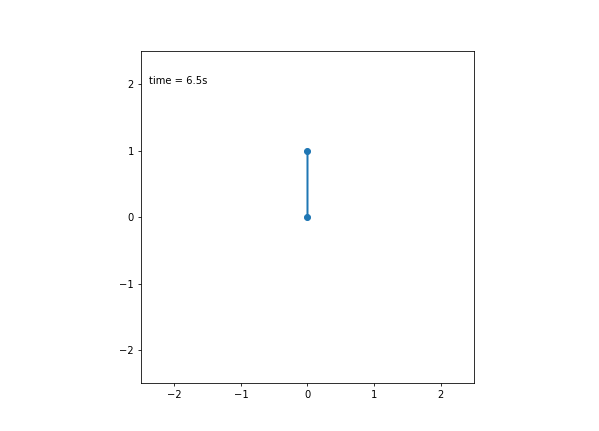

L=1.000 m
m=1.000 kg
g=9.810 m/s^2
b=0.000
Theta_init=-0.785 rad
Omega_init=3.000 rad/s
K_Lyap=0.500
E_des=9.810
th_des=3.142 rad
om_des=0.000 rad/s
dt=0.025 sec


In [6]:
#Simulation for different initial states

#Set the matplotlib animation to show 1 figure during the animation
%matplotlib nbagg

pend.PendulumParameters(th_init=-np.pi/4,om_init=3)
theta_sim,omega_sim,u_sim,E_sim,j2=pend.simulate(n)

#Define the figure for the animation
fig = plt.figure(figsize=(8.333, 6), dpi=80)
ax = fig.add_subplot(111,autoscale_on=False, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))   
ax.set_aspect('equal')
line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(pend.dt, 0.9, '', transform=ax.transAxes)

#Print the parameters of the simulation
pend.printParams()

#Show the animation
ani = animation.FuncAnimation(fig, animate, range(0, n), interval=pend.dt*1000, blit=True, init_func=init)
plt.show()

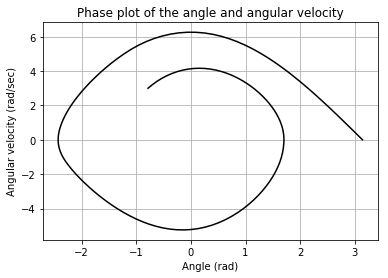

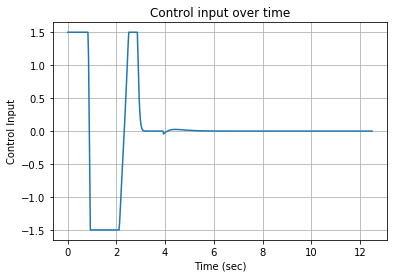

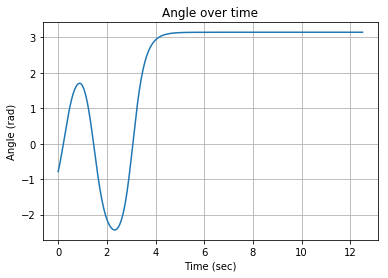

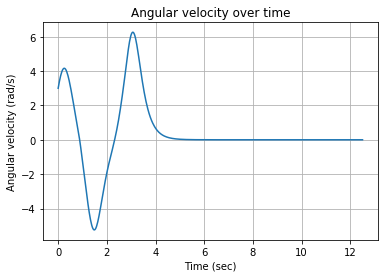

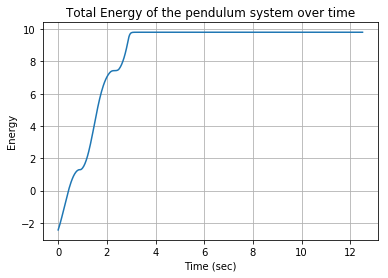

In [7]:
#Set the matplotlib plots to show the plots properly
%matplotlib inline

t=np.linspace(0,pend.dt*n,n)    #Create the time array

#Show the phase plot of the angle and angular velocity
plt.figure(0)
plt.plot(theta_sim,omega_sim,'k-')
plt.title("Phase plot of the angle and angular velocity")
plt.xlabel("Angle (rad)")
plt.ylabel("Angular velocity (rad/sec)")
plt.grid()

#Show the plot of the control input over time
plt.figure(1)
plt.plot(t,u_sim)
plt.title("Control input over time")
plt.xlabel("Time (sec)")
plt.ylabel("Control Input")
plt.grid()

#Show the angle of the pendulum over time
plt.figure(2)
plt.plot(t,theta_sim)
plt.title("Angle over time")
plt.xlabel("Time (sec)")
plt.ylabel("Angle (rad)")
plt.grid()

#Show the angular velocity of the pendulum over time
plt.figure(3)
plt.plot(t,omega_sim)
plt.title("Angular velocity over time")
plt.xlabel("Time (sec)")
plt.ylabel("Angular velocity (rad/s)")
plt.grid()

#Show the total energy of the pendulum over time
plt.figure(4)
plt.plot(t,E_sim)
plt.title("Total Energy of the pendulum system over time")
plt.xlabel("Time (sec)")
plt.ylabel("Energy")
plt.grid()